In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False


Bad key "text.kerning_factor" on line 4 in
/home/batu/anaconda3/envs/rnn/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
PATH = "tmp/df_1minute_1yearago"
df = pd.read_feather(PATH)

In [3]:
#import time
#for i in range(len(df)):
#    temp = df.iloc[i][6]
#    temp = temp[:-3]
#    temp = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(int(temp)))
#    df.iloc[i][6] = temp    
#    print(temp)
#df.to_feather(PATH)

In [4]:
TRAIN_SPLIT = 400000

In [5]:
# all values to float (except date)
df_temp = df.drop(['open time','close time'], axis=1).astype('float')
df_temp.insert(loc= 0, column='open time', value=df['open time'])
df_temp.insert(loc= 6, column='close time', value=df['close time'])
df = df_temp

In [6]:
features_considered = ['open','close','high','low','volume']

In [7]:
features = df[features_considered]
features.index = df['close time']
features.head()

,open,close,high,low,volume
close time,,,,,
2019-02-27 12:42:59,3822.81,3822.88,3822.98,3822.02,10.450780
2019-02-27 12:43:59,3822.88,3821.84,3822.90,3821.83,23.876892
2019-02-27 12:44:59,3821.86,3821.77,3822.75,3821.00,14.931546
2019-02-27 12:45:59,3821.50,3823.00,3823.08,3821.00,12.137765
2019-02-27 12:46:59,3822.77,3819.99,3822.96,3819.33,17.135062


In [8]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
dataset = (dataset-data_mean)/data_std

In [9]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [10]:
tf.random.set_seed(13)
past_history = 720
future_target = 72
STEP = 6
BATCH_SIZE = 256
BUFFER_SIZE = 10000
EVALUATION_INTERVAL = 400
EPOCHS = 10

x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

In [11]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [12]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

In [13]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(72))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

In [14]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Train for 400 steps, validate for 50 steps
Epoch 1/10
400/400 [==============================] - 35s 88ms/step - loss: 0.2752 - val_loss: 0.0382
Epoch 2/10
400/400 [==============================] - 32s 80ms/step - loss: 0.0669 - val_loss: 0.0228
Epoch 3/10
400/400 [==============================] - 32s 80ms/step - loss: 0.0451 - val_loss: 0.0756
Epoch 4/10
400/400 [==============================] - 32s 80ms/step - loss: 0.0276 - val_loss: 0.0887
Epoch 5/10
400/400 [==============================] - 32s 80ms/step - loss: 0.0556 - val_loss: 0.0191
Epoch 6/10
400/400 [==============================] - 32s 79ms/step - loss: 0.0382 - val_loss: 0.0132
Epoch 7/10
400/400 [==============================] - 32s 80ms/step - loss: 0.0300 - val_loss: 0.0308
Epoch 8/10
400/400 [==============================] - 32s 79ms/step - loss: 0.0272 - val_loss: 0.0413
Epoch 9/10
400/400 [==============================] - 32s 79ms/step - loss: 0.0389 - val_loss: 0.0102
Epoch 10/10
400/400 [==================

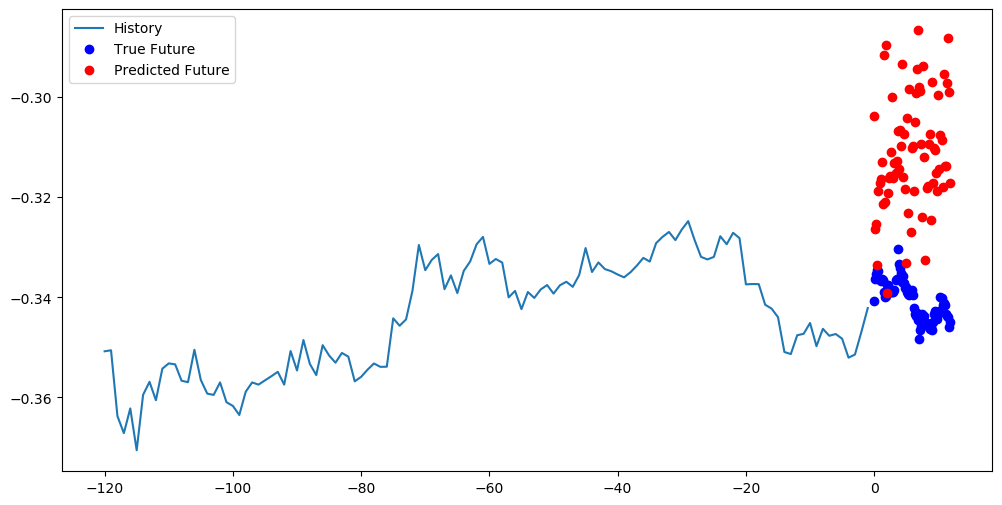

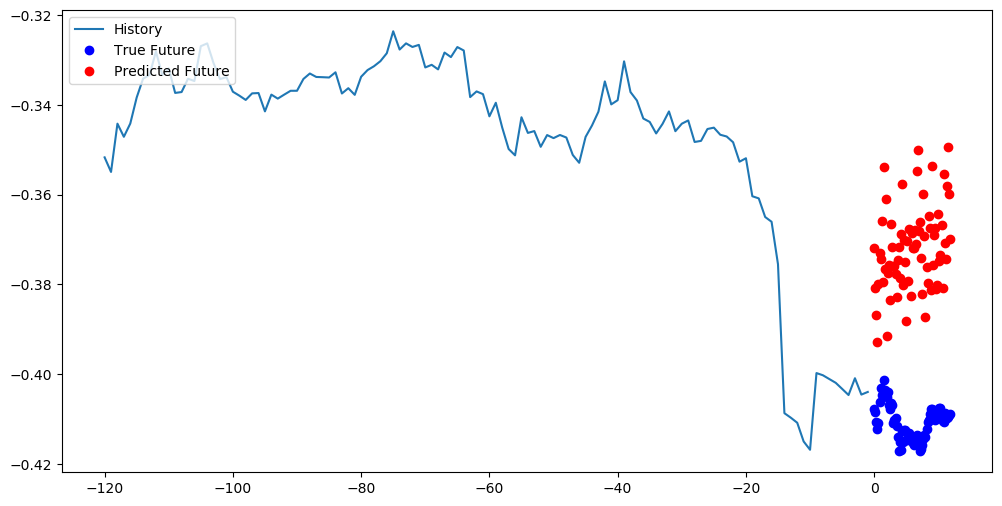

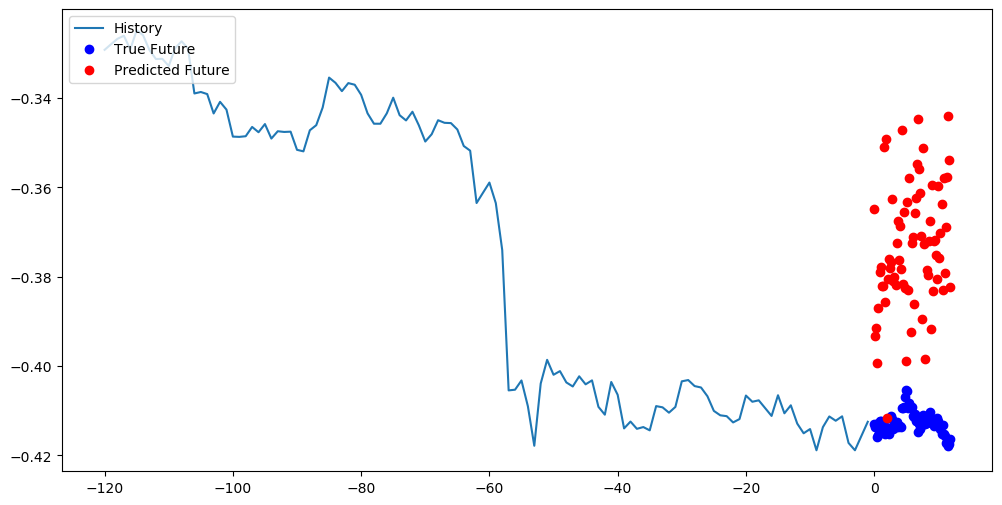

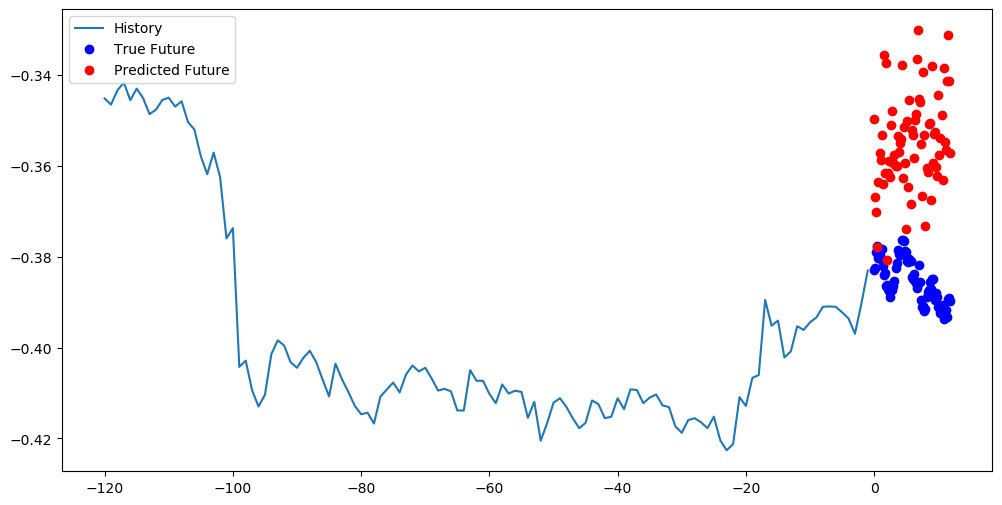

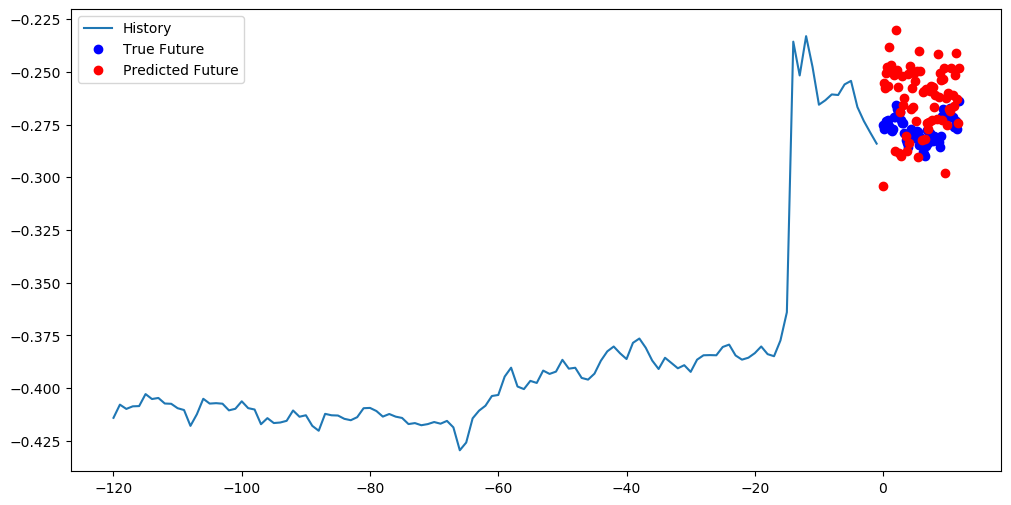

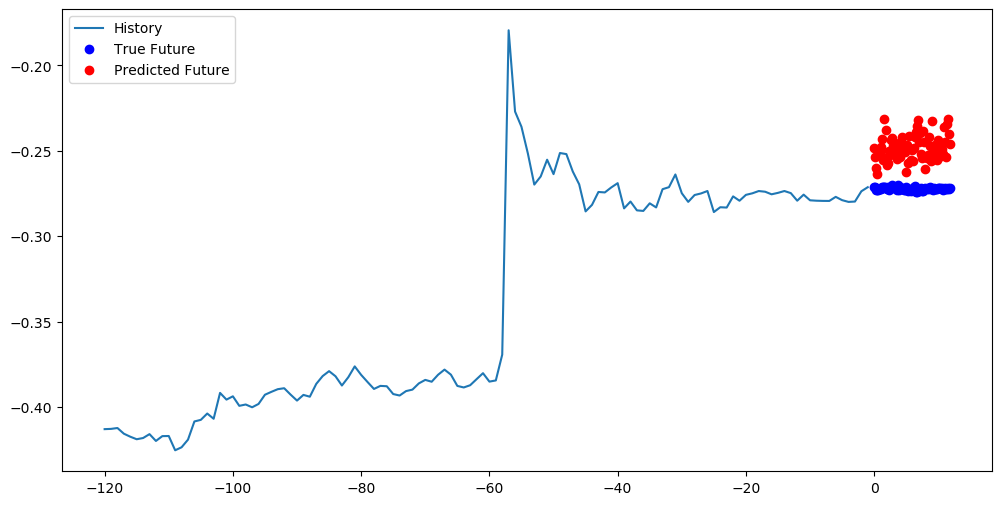

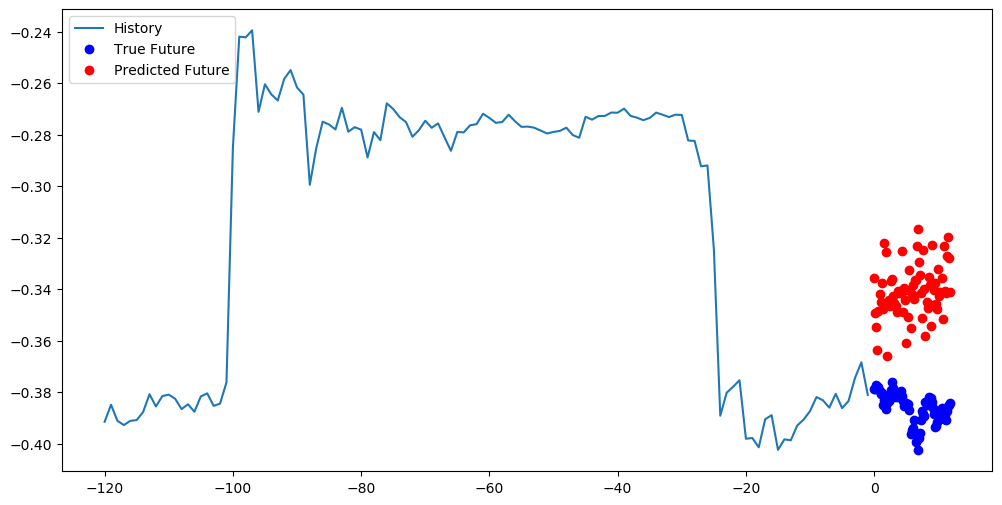

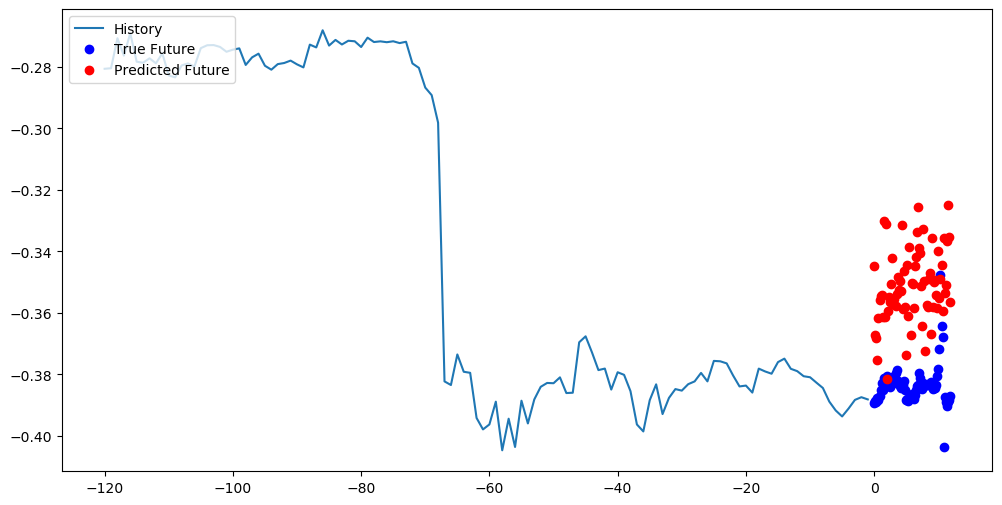

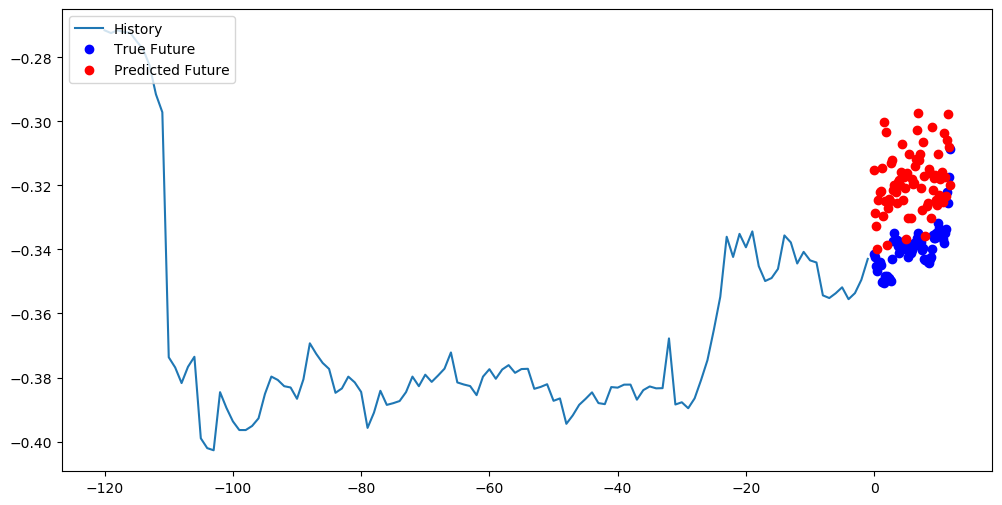

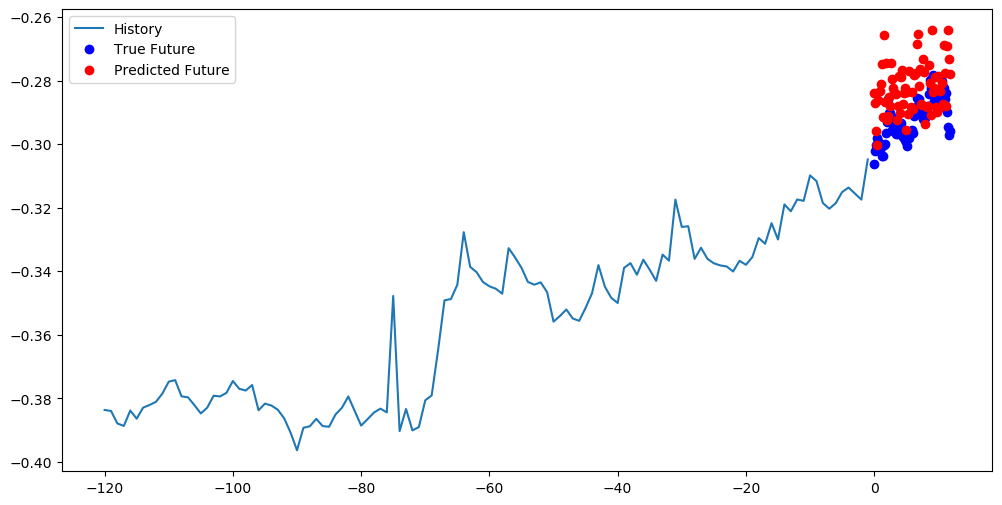

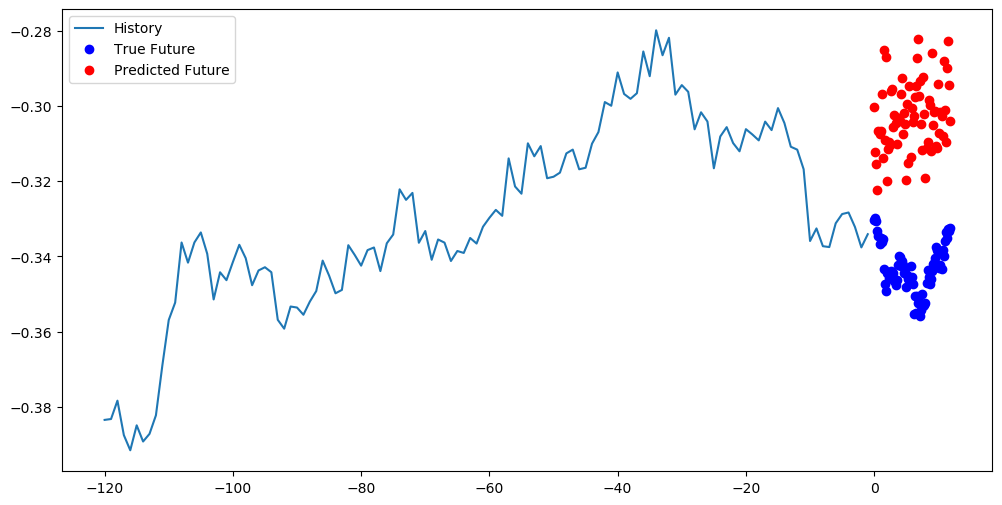

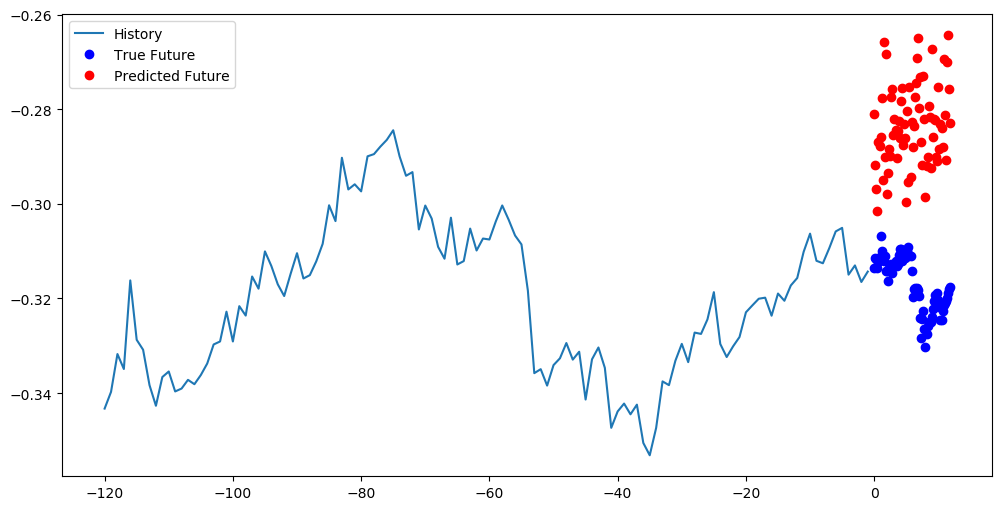

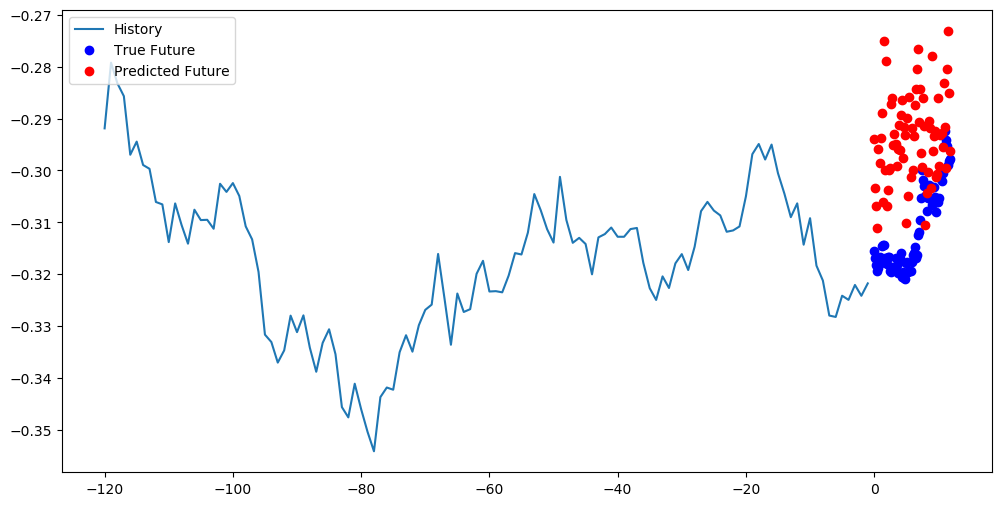

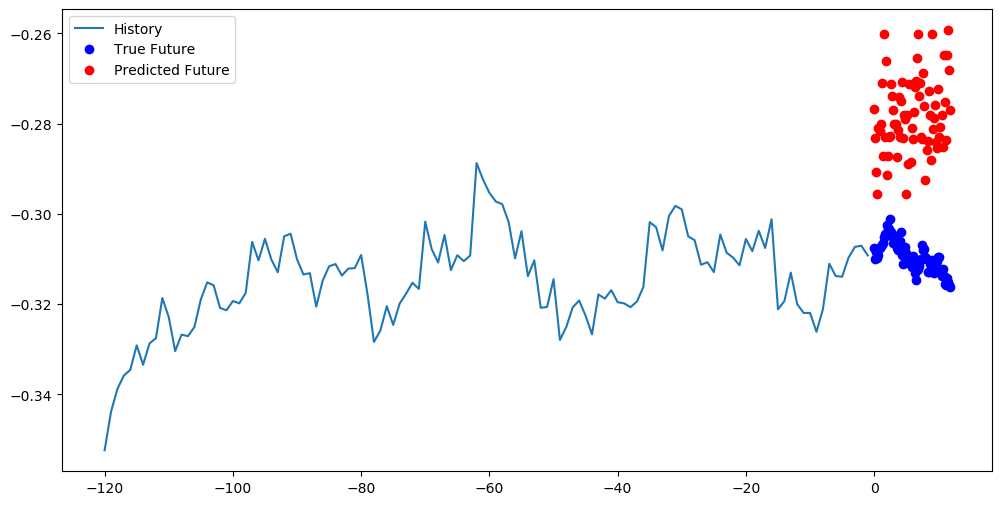

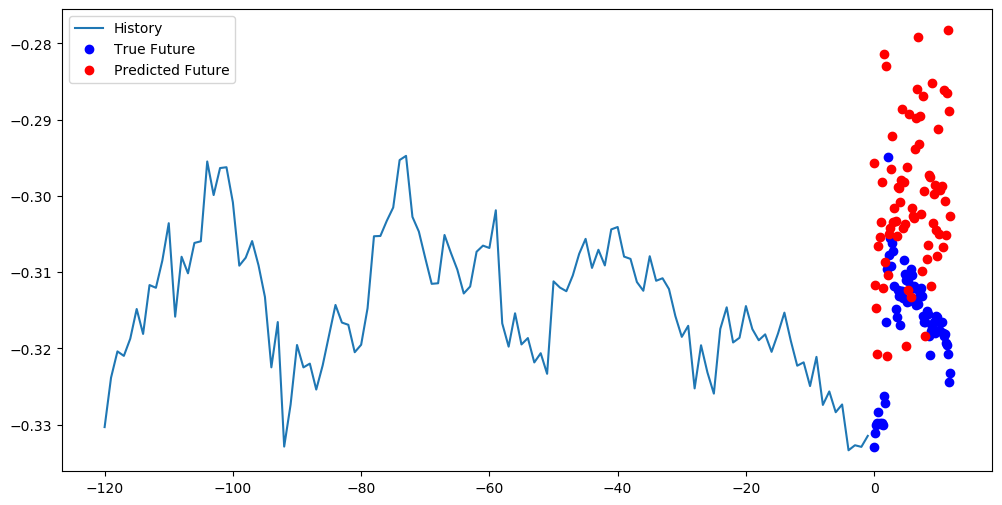

In [15]:
jtplot.reset()
def create_time_steps(length):
  return list(range(-length, 0))

def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

for x, y in val_data_multi.take(15):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])